## Phase image classification using U-Net_Cell_Neurite models

In [34]:
from data_128 import *
import matplotlib.pyplot as plt
from keras.models import load_model
from empatches import EMPatches
import imgviz # just for plotting
import numpy as np
from matplotlib import pyplot as plt
from glob import glob
from PIL import Image
import cv2
import os

(799, 799)


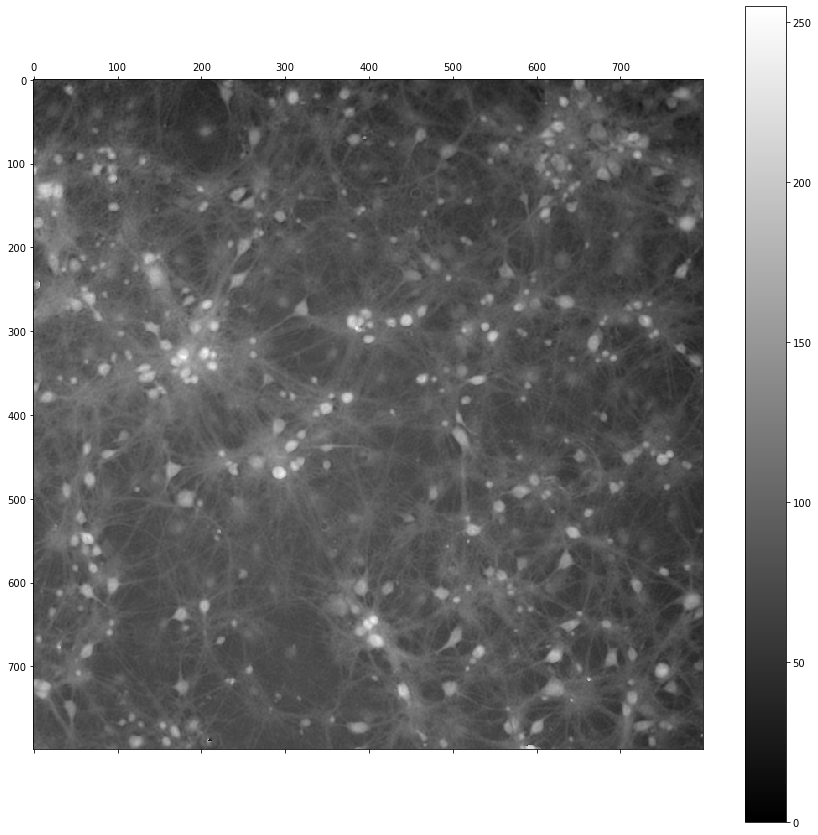

In [108]:
# get image either RGB or Grayscale
DHM_img = io.imread('/Users/behnazyazdani/U_Net_Cell_Neurite/Data/DHM_img/RatNeuron_5_666_Bw_2_5X.tif')
print(DHM_img.shape)
plt.figure(figsize=(15,15))
plt.matshow(DHM_img, cmap='gray', fignum=0)
plt.colorbar()
plt.show()

### Extract patches

In [109]:
emp = EMPatches()
overlap=0.2
img_patches, indices = emp.extract_patches(DHM_img, patchsize=128, overlap=0.2) #0.2

#### Displaying image patches

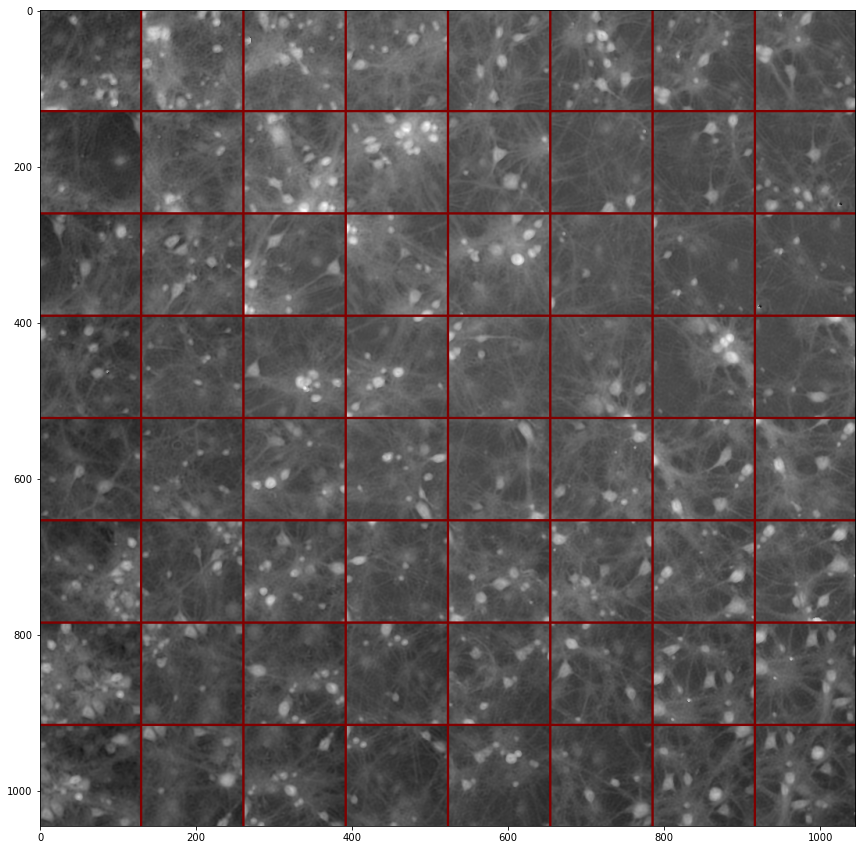

In [110]:
tiled= imgviz.tile(list(map(np.uint8, img_patches)),border=(128,0,0))
plt.figure(figsize=(15,15))
plt.imshow(tiled)
#plt.matshow(img_patches[19], cmap = 'gray')

### Save patches

In [112]:
#for i in range(8):
 #   for j in range(8):
        #print(i,j)
  #      index = j * 8 + i
   #     patch = img_patches[i * 8 + j]
    #    io.imsave('/Users/behnazyazdani/Unet_Cells/patch_processing/img/'+'RatNeuron_3_666_Bw_2_5X_'+str(i)+'_'+str(j)+".tif",patch[::-1, :])

### This function change patches in to the arrays that are compatible with model layer

`testGenerator` function in `data_128.py` is not compatibale with ` EMPatches` module, hence we should use the following function.

In [142]:
def testGenerators(arr,num_image = 64,target_size = (128,128),flag_multi_class = False,as_gray = True):
    for i in range(len(arr)):
        img = arr[i]
        img = trans.resize(img,target_size)
        img = np.reshape(img,img.shape+(1,)) if (not flag_multi_class) else img
        img = np.reshape(img,(1,)+img.shape)
        img = cv2.normalize(img, None, alpha = 0.0, beta = 1.0, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
        yield img

### Load `DHM_Cell.hdf5` model and segment patches

In [143]:
cell_model = load_model('DHM_Cell.hdf5')

In [144]:
#prediction
c_arr = np.array(img_patches)
NUM_TEST_IMAGES= len(c_arr)
testGene = testGenerators(c_arr)
print(type(testGene))
print(np.shape(testGene))
c_results = cell_model.predict_generator(testGene,NUM_TEST_IMAGES,verbose=1)

<class 'generator'>
()
 1/64 [..............................] - ETA: 42s

2023-01-11 15:31:05.109060: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


64/64 [==============================] - 2s 28ms/step


### Show large image predictation result after merging segmented patches with different overlapping modes.

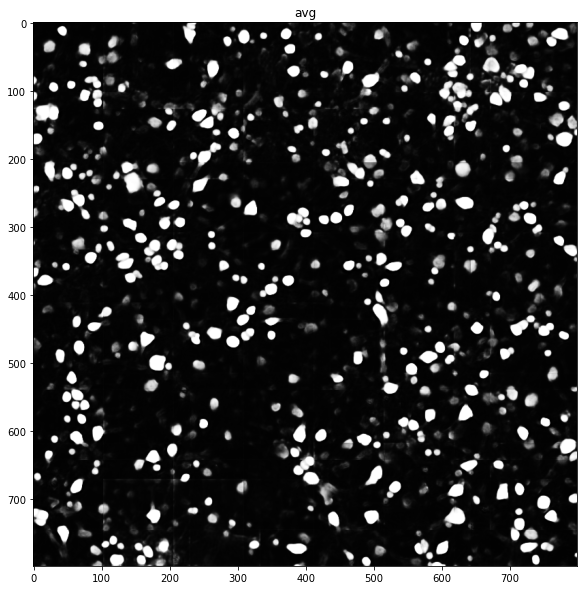

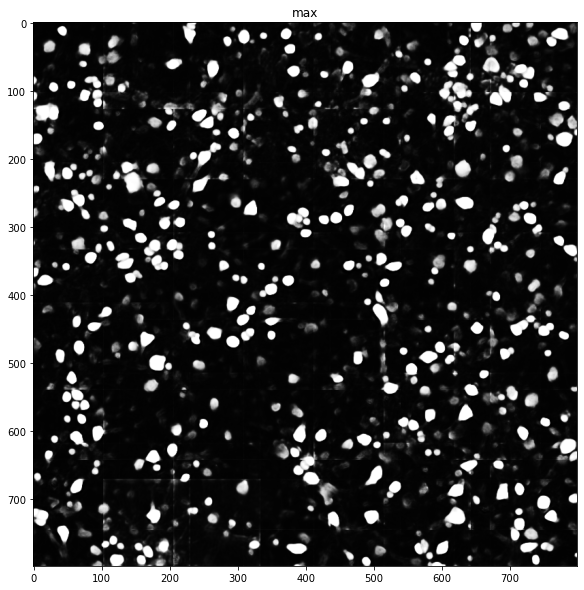

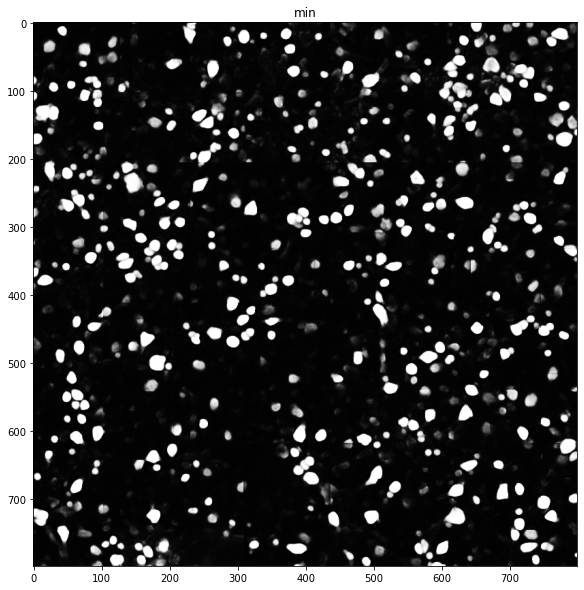

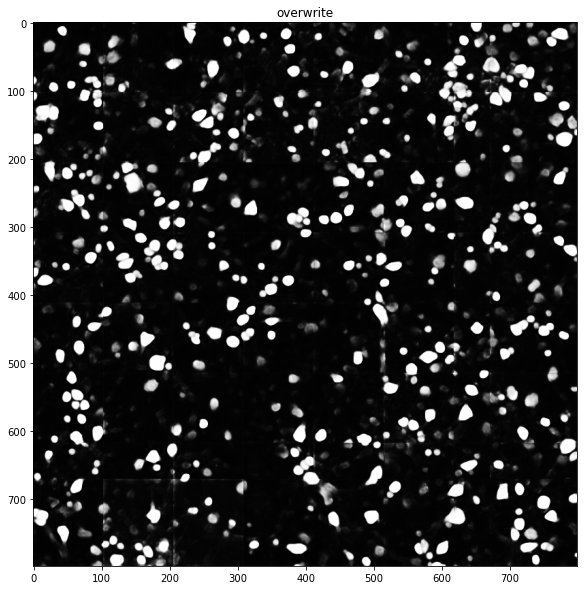

In [145]:
mode = ['avg','max','min','overwrite']
for i in range (len(mode)):
    merged_img = emp.merge_patches(c_results, indices, mode=str(mode[i]))
    plt.figure(figsize=(10,10))
    plt.imshow(merged_img,cmap='gray')
    #plt.imshow(merged_img.astype(np.uint8),cmap='gray')
    plt.title(str(mode[i]))
    io.imsave('/Users/behnazyazdani/U_Net_Cell_Neurite/Data/PDHM_Prediction/Cell/'+'U_Cell_RatNeuron_5_666_Bw_2_5X'+'_'+str(mode[i])+'_'+str(overlap)+".tif",merged_img)

### Load `DHM_Neurite.hdf5` model and segment patches

In [146]:
neurite_model = load_model('DHM_Neurite.hdf5')

In [147]:
#prediction
n_arr = np.array(img_patches)
NUM_TEST_IMAGES= len(n_arr)
testGene = testGenerators(n_arr)
print(type(testGene))
print(np.shape(testGene))
n_results = neurite_model.predict_generator(testGene,NUM_TEST_IMAGES,verbose=1)

<class 'generator'>
()
 1/64 [..............................] - ETA: 40s

2023-01-11 15:31:10.358943: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


64/64 [==============================] - 2s 28ms/step


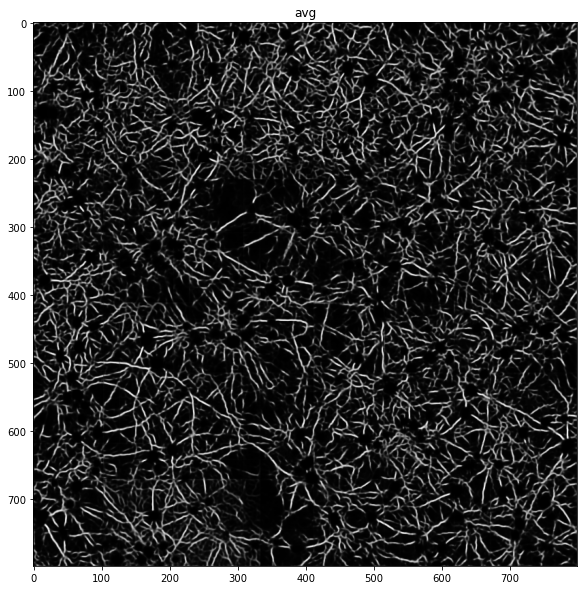

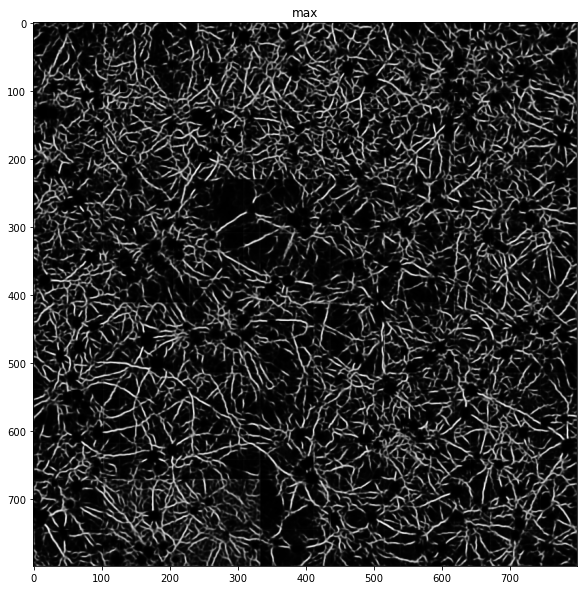

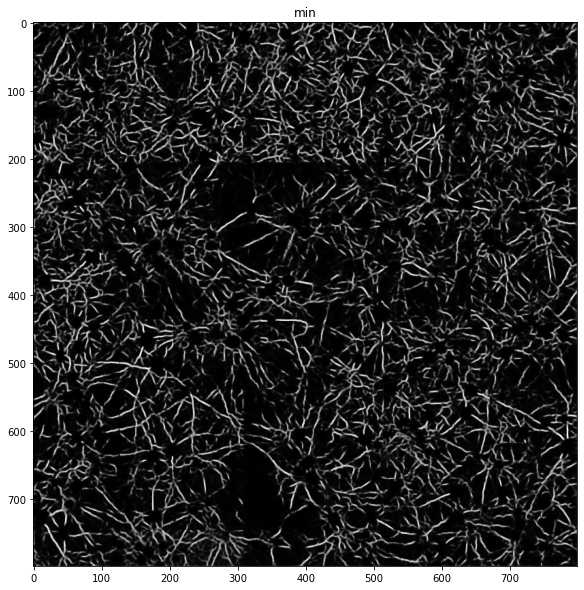

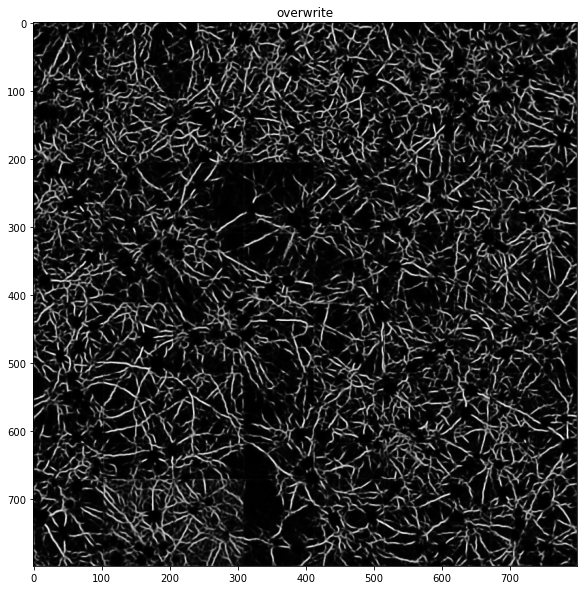

In [148]:
mode = ['avg','max','min','overwrite']
for i in range (len(mode)):
    merged_img = emp.merge_patches(n_results, indices, mode=str(mode[i]))
    plt.figure(figsize=(10,10))
    plt.imshow(merged_img,cmap='gray')
    #plt.imshow(merged_img.astype(np.uint8),cmap='gray')
    plt.title(str(mode[i]))
    io.imsave('/Users/behnazyazdani/U_Net_Cell_Neurite/Data/PDHM_Prediction/Neurite/'+'U_Neurite_RatNeuron_5_666_Bw_2_5X'+'_'+str(mode[i])+'_'+str(overlap)+".tif",merged_img)

### Combining two prediction map with `cv2.addWeighted` function

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(799, 799, 3)


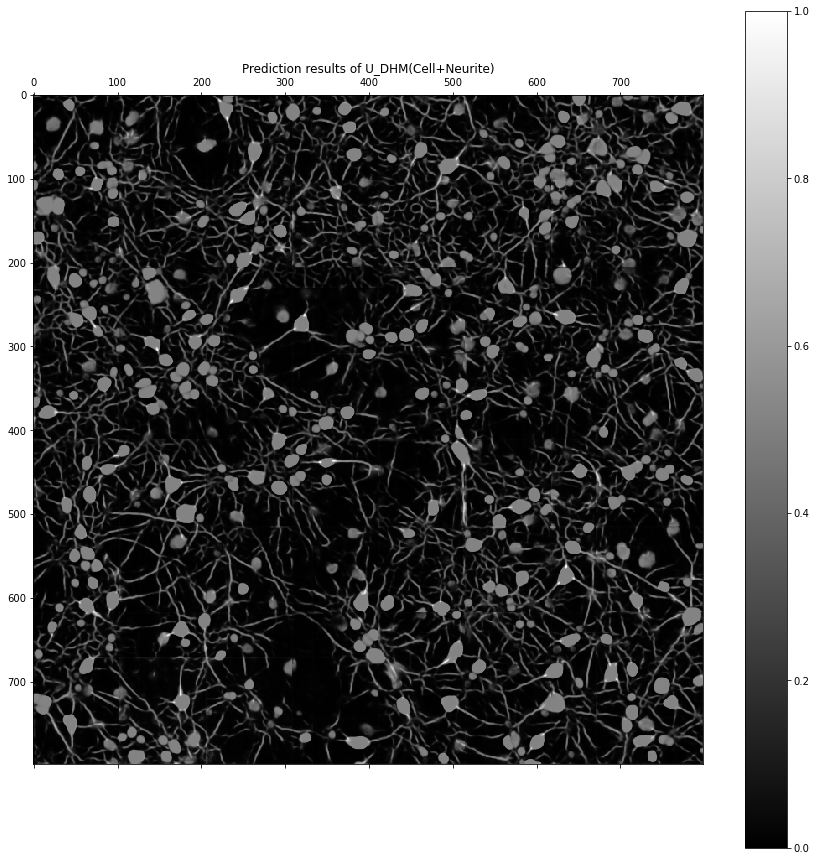

In [149]:

img1 = io.imread("/Users/behnazyazdani/U_Net_Cell_Neurite/Data/PDHM_Prediction/Cell/U_Cell_RatNeuron_5_666_Bw_2_5X_overwrite_0.2.tif")
img2 = io.imread("/Users/behnazyazdani/U_Net_Cell_Neurite/Data/PDHM_Prediction/Neurite/U_Neurite_Avrg_Bw_5X_5_avg_0.2.tif")
 
# OpenCV expects to get BGR images,  convert from BGR to RGB
 
img1 = cv2.cvtColor(img1, cv2.COLOR_GRAY2RGB)
img2 = cv2.cvtColor(img2, cv2.COLOR_GRAY2RGB)
print(img1.shape)

blended = cv2.addWeighted(src1=img1,alpha=1,src2=img2,beta=0.9991,gamma=0)
img = cv2.normalize(blended, None, alpha = 0.0, beta = 1.0, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)

#  convert it from RGB to BGR, then save
 
cv2.imwrite('U_Neurite+Cell_RatNeuron_5_666_Bw_2_5X.tif',cv2.cvtColor(img, cv2.COLOR_RGB2GRAY))


plt.figure(figsize=(15, 15))
plt.matshow(img,cmap='gray', fignum=1)
plt.title('Prediction results of U_DHM(Cell+Neurite)')
plt.colorbar()
plt.show()